In [5]:
import mdtraj as md
import MDAnalysis as mda
import numpy as np
from scipy.stats import ttest_ind_from_stats

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
import deeptime.markov.msm as msm
import deeptime.markov.hmm as hmm

from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz
from deeptime.markov.sample import *
from deeptime.markov import TransitionCountEstimator
from deeptime.util import energy2d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from funcs_build_msm import _tica, _kmeans, get_data
from funcs_validate_msm import *
from funcs_sample import *
from funcs_plotting import *
from funcs_characterise import *
#from funcs_featurise import *
from funcs_abl_featurise import *
from paths import *

In [2]:
protein = 'abl'
study_name = 'n_clusters'
hp_id = 2
savedir = Path(f'data_{protein}/msm/validation/{study_name}_hp{hp_id}_validate')

n_states = 6

In [3]:
samples = [md.load(savedir/f'MS_{state_i+1}.pdb') for state_i in range(n_states)]

### Compute the RMSDs within each sampled states

In [50]:
for state_i in range(n_states):
    rmsd_mean, rmsd_std = cal_within_state_rmsd(samples[state_i])
    save_example_with_property(savedir/f'MS_{state_i+1}.pdb', rmsd_mean, savedir/f'MS_{state_i+1}_rmsd_mean.pdb')

### Compute the different scores between every two pairs of states

In [52]:
res_scores = []

for i in range(n_states):
    res_scores.append([])
    rmsd_mean_i, rmsd_std_i = cal_within_state_rmsd(samples[i])
    for j in range(n_states):
        if j > i:
            rmsd_mean_j, rmsd_std_j = cal_within_state_rmsd(samples[j])
            rmsd_mean_ij, rmsd_std_ij = cal_between_states_rmsd(samples[i], samples[j])
            res_scores[i].append(cal_between_states_diff(rmsd_mean_ij, rmsd_std_i, rmsd_std_j))

In [53]:
for i in range(n_states):
    for j in range(n_states-i-1):
            save_example_with_property(savedir/f'MS_{i+1}.pdb', res_scores[i][j], savedir/f'MS_{i+1}_{j+i+2}_score.pdb')

### Assign DFG motifs

In [6]:
dists = []
state = []
for i, sample in enumerate(samples):
    state.extend([i]*len(sample))
    dists.extend(dbdist_featuriser(sample, save_to_disk=None))
dists = np.array(dists)

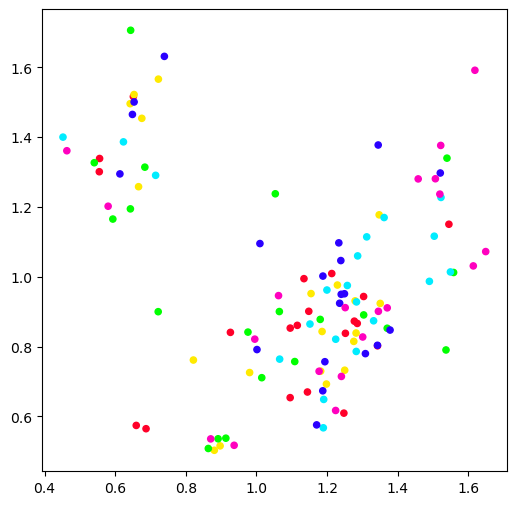

In [7]:
cmap = 'gist_rainbow'
n_states = 6
cmap = mpl.colormaps[f'{cmap}'].resampled(n_states)
norm = colors.BoundaryNorm(list(range(0, n_states+1)), n_states, clip=True)

fig, ax = plt.subplots(1,1,figsize=(6, 6))

ax.scatter(dists[:,0], dists[:,1], s=20, c=state, cmap=cmap, norm=norm)

### Assign aC-helix 

In [8]:
ac_dists = []
ac_state = []
for i, sample in enumerate(samples):
    ac_state.extend([i]*len(sample))
    ac_dists.extend(achelix_featuriser(sample, save_to_disk=None))
ac_dists = np.array(ac_dists)

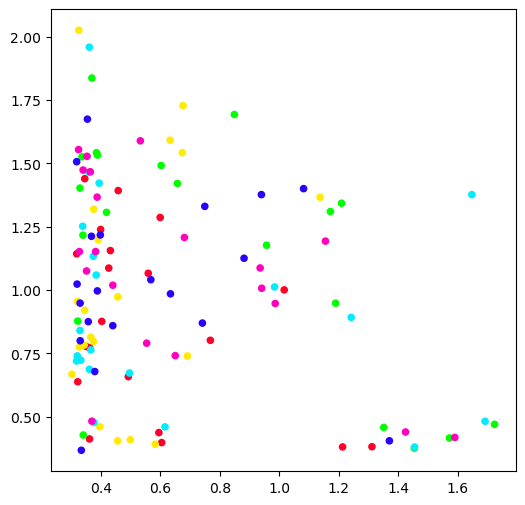

In [9]:
cmap = 'gist_rainbow'
n_states = 6
cmap = mpl.colormaps[f'{cmap}'].resampled(n_states)
norm = colors.BoundaryNorm(list(range(0, n_states+1)), n_states, clip=True)

fig, ax = plt.subplots(1,1,figsize=(6, 6))

ax.scatter(ac_dists[:,0], ac_dists[:,1], s=20, c=state, cmap=cmap, norm=norm)

### Identify the closest crystal structures

Compute the RMSDs between samples from each pcca state and all crystal structures. Find the crystal structure with the lowest average RMSD. The RMSD is calculated using the heavy atoms of the p-loop, a-loop, and the aC-helix. 

In [10]:
pdb_files = natsorted([pdb for pdb in Path(f'/arc/human_{protein}').rglob('*.pdb')])
pdbs = [md.load(pdb) for pdb in pdb_files]
pdbs = [pdb.atom_slice(pdb.topology.select('protein and mass > 1.1')) for pdb in pdbs]
pdb_traj = md.join(pdbs)

In [100]:
pdb_traj.superpose(samples[0])
pdb_traj.save("data_egfr/samples/pdb_traj.pdb")

In [106]:
top = pdb_traj.topology
ala755_id = np.where([str(res) == 'ALA755' for res in top.residues])[0][0]
asp770_id = np.where([str(res) == 'ASP770' for res in top.residues])[0][0]

asp855_id = np.where([str(res) == 'ASP855' for res in top.residues])[0][0]
pro877_id = np.where([str(res) == 'PRO877' for res in top.residues])[0][0]

ile715_id = np.where([str(res) == 'ILE715' for res in top.residues])[0][0]
gly729_id = np.where([str(res) == 'GLY729' for res in top.residues])[0][0]

In [108]:
rmsd_matrix = np.zeros((len(samples), 20, len(pdbs)))
atom_selection = pdb_traj.topology.select(f"mass > 1.1 and (resid {ala755_id} to {asp770_id} or resid {asp855_id} to {pro877_id} or resid {ile715_id} to {gly729_id})")
for i, sample in enumerate(samples):
    for j, conf in enumerate(sample):
        pdb_traj.superpose(conf, atom_indices=pdb_traj.topology.select("name == 'CA'"))
        rmsd_matrix[i, j, :] = md.rmsd(pdb_traj, sample[j], atom_indices=atom_selection)

rmsd_averaged = np.mean(rmsd_matrix, axis=1)

In [109]:
for i in range(n_states):
    min_rmsd = np.min(rmsd_averaged[i, :])
    min_rmsd_idx = np.argmin(rmsd_averaged[i, :])
    name = pdb_files[min_rmsd_idx].stem
    print(min_rmsd, min_rmsd_idx, name)

0.3428647443652153 39 kinoml_OEKLIFSKinaseApoFeaturizer_EGFR_2rf9_chainB_altlocNone_protein
0.39925216138362885 218 kinoml_OEKLIFSKinaseApoFeaturizer_EGFR_5uwd_chainA_altlocNone_protein
0.3487804070115089 34 kinoml_OEKLIFSKinaseApoFeaturizer_EGFR_2jiu_chainB_altlocNone_protein
0.31131797656416893 134 kinoml_OEKLIFSKinaseApoFeaturizer_EGFR_4zjv_chainB_altlocB_protein
0.2169695995748043 344 kinoml_OEKLIFSKinaseApoFeaturizer_EGFR_6v6k_chainD_altlocNone_protein
0.32484033405780793 271 kinoml_OEKLIFSKinaseApoFeaturizer_EGFR_6jwl_chainA_altlocNone_protein


### H-bond distances in alpha-C helix in state 1 

In [110]:
lys757_id = np.where([str(res) == 'LYS757' for res in top.residues])[0][0]
ser768_id = np.where([str(res) == 'SER768' for res in top.residues])[0][0]
lys757_id, ser768_id

(54, 65)

In [117]:
phi, psi = [], []

for sample in samples: 
    phi.append(md.compute_phi(sample)[1])
    psi.append(md.compute_psi(sample)[1])

phi = np.concatenate(phi)
psi = np.concatenate(psi)

### Inspect DFG samples

In [3]:
dfg_in_mean, dfg_in_std = cal_within_state_rmsd(dfg_in_samples)
dfg_out_mean, dfg_out_std = cal_within_state_rmsd(dfg_out_samples)
in_out_mean, in_out_std = cal_between_states_rmsd(dfg_in_samples, dfg_out_samples)
score = cal_between_states_diff(in_out_mean, dfg_in_std, dfg_out_std)

In [4]:
save_example_with_property("./data_egfr/msm/dunbrack_studies/lag100_random_trials/61/MS_0.pdb", score, 'rmsd_diff_dfg-in-out.pdb')

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [ ]:
save_example_with_property("./data_egfr/msm/dunbrack_studies/lag100_random_trials/61/MS_0.pdb", score, 'rmsd_diff_dfg-in-out.pdb')

In [ ]:
save_example_with_property("./data_egfr/msm/dunbrack_studies/lag100_random_trials/61/MS_0.pdb", score, 'rmsd_diff_dfg-in-out.pdb')